### Regression Tree and Random Forest Models
> The purpose of this notebook is to explore using regression trees and random forests for predictive analytics. I plan on using the crime data set uscrime.txt and fitting a 
(a) a regression tree model, and (b) a random forest model for comparison

### Regression Tree Model

To create the regression tree model I'll use the rpart package. For the random forest I'll use the randomForest package. I found this article helpful in understanding how to create the decision tree and random forest: https://quantdev.ssri.psu.edu/tutorials/introduction-classification-regression-trees.

1) Explore the data to gain a better understanding of the dataset
2) Normalize the data
3) Look at correlation values
4) Apply the PCA
5) Determine optimal number of principal components
6) Create new linear regression model in terms of the original variables
7) Compare the new models

#### Step 1 - Explore the Data
For this step I am going to visually inspect the data, get summary statistics to get a sense of the properties of the values in the data, and read about the data to understand what each value represents.  I'll start by loading the libraries I need for this analysis and loading the data.

In [37]:
# Set seed so output is reproducible
set.seed(123)

# Load libraries needed for analysis
library(ggplot2) # for plots
library(dplyr) # includes pipeline operator
library(rpart) # tree model
library(rpart.plot) # visualizing the tree model
library(rattle) # another way to visualize the tree model
library(randomForest) # random forest model
library(caret) # for performing cross-validation
library(cowplot) # for creating grid of plots
library(pROC) # creating ROC curves

In [2]:
# Load the data
crime_data <- read.table("uscrime.txt", header = TRUE)

In [3]:
# Visually inspect the data, for this report I only printed the first few rows but inspected all of them
head(crime_data[,1:10])
head(crime_data[,11:16])

M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1
15.1,1,9.1,5.8,5.6,0.510,95.0,33,30.1,0.108
14.3,0,11.3,10.3,9.5,0.583,101.2,13,10.2,0.096
14.2,1,8.9,4.5,4.4,0.533,96.9,18,21.9,0.094
13.6,0,12.1,14.9,14.1,0.577,99.4,157,8.0,0.102
14.1,0,12.1,10.9,10.1,0.591,98.5,18,3.0,0.091
12.1,0,11.0,11.8,11.5,0.547,96.4,25,4.4,0.084


U2,Wealth,Ineq,Prob,Time,Crime
4.1,3940,26.1,0.084602,26.2011,791
3.6,5570,19.4,0.029599,25.2999,1635
3.3,3180,25.0,0.083401,24.3006,578
3.9,6730,16.7,0.015801,29.9012,1969
2.0,5780,17.4,0.041399,21.2998,1234
2.9,6890,12.6,0.034201,20.9995,682


I don't like the labels for some of the columns in the data as it is hard to understand what they represent just by their name. A description of the attributes taken from the website can be seen below. Next, I am going to rename my columns to match the descriptions a little better. I am also going to make a couple of tweaks to the data, I am going to turn the LF, M.F, U1, and Prob variables into percentages to match the M, NW, U2 and Ineq variables. It seems odd that the U2 variable would be as a percentage and the U1 variable is set as a ratio since they represent the same thing for different age groups. I also just want the consistency of having everything listed as a percentage. I will of course have to apply the same transformation to the values from the data point we are trying to predict or to the coefficients of the final model.

    M:      percentage of males aged 14-24 in total state population
    So:     indicator variable for Southern states (0 = No, 1 = Yes)
    Ed:     mean years of schooling of the population aged 25 years or over
    Po1:    per capita expenditure on police protection in 1960
    Po2:    per capita expenditure on police protection in 1959
    LF:     labor force participation rate of civilian urban males in the age-group 14-24
    M.F:    number of males per 100 females
    Pop:    state population size in hundred thousands
    NW:     percentage of nonwhites in the population
    U1:     unemployment rate of urban males 14-24
    U2:     unemployment rate of urban males 35-39
    Wealth: median value of transferable assets or family income
    Ineq:   percentage of families earning below half the median income
    Prob:   probability of imprisonment: ratio of number of commitments to number of offenses
    Time:   average time in months served by offenders in state prisons before their first release
    Crime:  number of offenses per 100,000 population in 1960

In [4]:
# Assign more meaningful variable names and update several values in the dataset (not necessary but it makes it easier for me to interpret)
# %>% is a pipe operator that allows several operations (rename and mutate) to occur
crime_data <- crime_data %>%
  rename(percent_young_male = M,
         southern_state = So,
         average_ed = Ed,
         per_cap_exp_1960 = Po1,
         per_cap_exp_1959 = Po2,
         laborforce_part = LF,
         percent_male = M.F,
         population = Pop,
         nonwhite = NW,
         unemp_youth = U1,
         unemp_adult = U2,
         median_assets = Wealth,
         low_income = Ineq,
         prob_imprisonment = Prob,
         time_served = Time,
         crimes_per_million = Crime) %>%
  mutate(laborforce_part = laborforce_part * 100,
         percent_male = (percent_male / (percent_male + 100)) * 100,
         unemp_youth = unemp_youth * 100,
         prob_imprisonment = prob_imprisonment * 100)

# print summary of the transformed data
summary(crime_data)

 percent_young_male southern_state     average_ed    per_cap_exp_1960
 Min.   :11.90      Min.   :0.0000   Min.   : 8.70   Min.   : 4.50   
 1st Qu.:13.00      1st Qu.:0.0000   1st Qu.: 9.75   1st Qu.: 6.25   
 Median :13.60      Median :0.0000   Median :10.80   Median : 7.80   
 Mean   :13.86      Mean   :0.3404   Mean   :10.56   Mean   : 8.50   
 3rd Qu.:14.60      3rd Qu.:1.0000   3rd Qu.:11.45   3rd Qu.:10.45   
 Max.   :17.70      Max.   :1.0000   Max.   :12.20   Max.   :16.60   
 per_cap_exp_1959 laborforce_part  percent_male     population    
 Min.   : 4.100   Min.   :48.00   Min.   :48.29   Min.   :  3.00  
 1st Qu.: 5.850   1st Qu.:53.05   1st Qu.:49.10   1st Qu.: 10.00  
 Median : 7.300   Median :56.00   Median :49.42   Median : 25.00  
 Mean   : 8.023   Mean   :56.12   Mean   :49.56   Mean   : 36.62  
 3rd Qu.: 9.700   3rd Qu.:59.30   3rd Qu.:49.80   3rd Qu.: 41.50  
 Max.   :15.700   Max.   :64.10   Max.   :51.71   Max.   :168.00  
    nonwhite      unemp_youth      unemp_

#### Step 2 - Grow a Tree
Now that the data is loaded I will grow the tree! I am using the rpart() package and since I am interested in a regression tree I will set the method to "anova". I also played with some of the control paramaters including setting the minimum number of observations in a node before a split is attempted (minsplit), how much each split must decrease the overall lack of fit (cp), and the maximum depth of any node of the final tree (maxdepth - root node is counted as depth 0). It was interesting to see how these parameters affected the final model. Since I want practice pruning the tree I chose parameters that created more terminal nodes than the base model did.

Since the dataset is so small I didn't split it into training/testing data but will use cross-validation to analyze the model performance. This won't allow for an accurate errro estimation for the model but should give some insight into it's performance. More information about the rpart() function can be found here: https://www.rdocumentation.org/packages/rpart/versions/4.1.23/topics/rpart

In [5]:
# minimum number of points for the 5% rule of thumb
min_points <- ceiling(0.05 * nrow(crime_data))
cat("The minimum number of points in each branch needs to be", min_points, "to meet the 5% rule of thumb.", "\n\n")

# Grow tree without control parameters for comparison
crime_tree_default <- rpart(crimes_per_million ~ ., method = "anova", data = crime_data)
cat("Model without control parameters:", "\n")
crime_tree_default

# Grow the final tree using the control parameters (only ended up using the minsplit character which has a default of 20, the default for cp is 0.01)
crime_tree <- rpart(crimes_per_million ~ ., method = "anova", data = crime_data, control = rpart.control(minsplit = 9))
cat("\n\n","Model with control parameters:", "\n")
crime_tree

The minimum number of points in each branch needs to be 3 to meet the 5% rule of thumb. 

Model without control parameters: 


n= 47 

node), split, n, deviance, yval
      * denotes terminal node

1) root 47 6880928.0  905.0851  
  2) per_cap_exp_1960< 7.65 23  779243.5  669.6087  
    4) population< 22.5 12  243811.0  550.5000 *
    5) population>=22.5 11  179470.7  799.5455 *
  3) per_cap_exp_1960>=7.65 24 3604162.0 1130.7500  
    6) nonwhite< 7.65 10  557574.9  886.9000 *
    7) nonwhite>=7.65 14 2027225.0 1304.9290 *



 Model with control parameters: 


n= 47 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 47 6880928.00  905.0851  
   2) per_cap_exp_1960< 7.65 23  779243.50  669.6087  
     4) population< 22.5 12  243811.00  550.5000  
       8) average_ed< 11.65 9   58820.89  484.1111 *
       9) average_ed>=11.65 3   26320.67  749.6667 *
     5) population>=22.5 11  179470.70  799.5455 *
   3) per_cap_exp_1960>=7.65 24 3604162.00 1130.7500  
     6) nonwhite< 7.65 10  557574.90  886.9000  
      12) percent_young_male< 13.05 6  109289.50  727.5000 *
      13) percent_young_male>=13.05 4   67160.00 1126.0000 *
     7) nonwhite>=7.65 14 2027225.00 1304.9290  
      14) median_assets< 6470 11  707252.70 1148.4550  
        28) prob_imprisonment>=4.10995 4   28226.00  898.0000 *
        29) prob_imprisonment< 4.10995 7  284739.70 1291.5710 *
      15) median_assets>=6470 3   63120.67 1878.6670 *

Inspecting the models above, the biggest difference is that the branch for per_cap_exp_1960 >= 7.65 splits the nonwhite branches additional times, and the branch for per_cap_exp_1960 < 7.65 splits the population < 22.5 an additional time. The default value for minsplit is 20 so by reducing it to 9 it allowed the model to create several more branches. The minbucket paramater is set to a default of (minstplit/3) which means it is equal to 3. This ensures that each terminal node had at least 5% of the data in it. I suspect I will still end up pruning most of the additional branches since they have a very small number of datapoints (3, 7, 4, 4, 6, 11, 3, and 9) which likely means the model is overfitting the data, but I am going to use the model that was created with control parameters to get more experience pruning.

#### Step 3 - Inspect the Tree
Next I am going to inspect the tree using a variety of plots and outputs.

In [6]:
# Get a detailed summary of the model
summary(crime_tree)

Call:
rpart(formula = crimes_per_million ~ ., data = crime_data, method = "anova", 
    control = rpart.control(minsplit = 9))
  n= 47 

          CP nsplit rel error   xerror      xstd
1 0.36296293      0 1.0000000 1.062718 0.2641620
2 0.16540024      1 0.6370371 1.131172 0.2744131
3 0.05730143      3 0.3062366 1.292726 0.3268601
4 0.05538867      4 0.2489352 1.152379 0.3190650
5 0.05173165      5 0.1935465 1.178961 0.3179641
6 0.02305931      6 0.1418148 1.172783 0.3249076
7 0.01000000      7 0.1187555 1.146689 0.3351339

Variable importance
  per_cap_exp_1959      median_assets   per_cap_exp_1960  prob_imprisonment 
                15                 14                 14                 12 
        low_income percent_young_male         average_ed           nonwhite 
                 8                  8                  8                  7 
   laborforce_part        time_served         population     southern_state 
                 4                  4                  3         

One of the interesting observations looking at the variable importance is that the model splits on per_cap_exp_1960 and doesn't include per_cap_exp_1959 despite it being listed as being more important. It also doesn't use prob_imprisonment, low_income, percent_young_male, or average_ed despite those variables having higher importance than some of the variables listed. I believe this is largely due to colinearity between those variables and the variables that were selected. Multicollinearity doesn't impact the prediction performance of the model. This is fairly intuitive but I found a good explanation of the why here: https://medium.com/@manepriyanka48/multicollinearity-in-tree-based-models-b971292db140. "If two features are corelated, any one of the feature will be selected for splitting based on score. So if one out of two is selected, the 2nd one will not be selected for next level of tree building as the variance or impurity is already explained by the 1st feature."

Next, I am going to plot the tree. I found multiple ways to do this including using the built in rpart.plot() function. I'm going to use two of the "fancier" options from the rpart.plot and rattle libraries to see which produces a nicer plot.

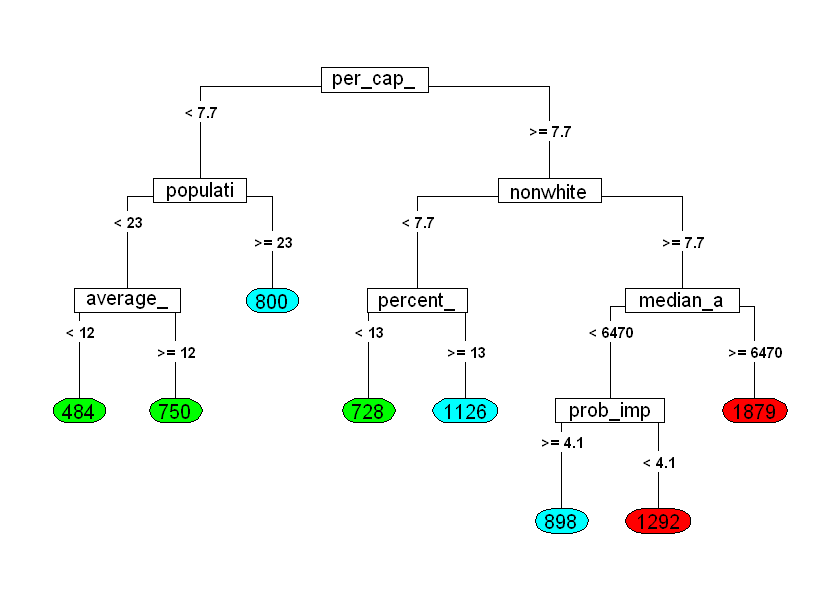

In [7]:
# Set the plot size
options(repr.plot.width=7, repr.plot.height=5)

# Plot the tree
prp(crime_tree, type = 5, branch = 1, box.palette=c("green", "cyan", "red"), split.cex = .75)

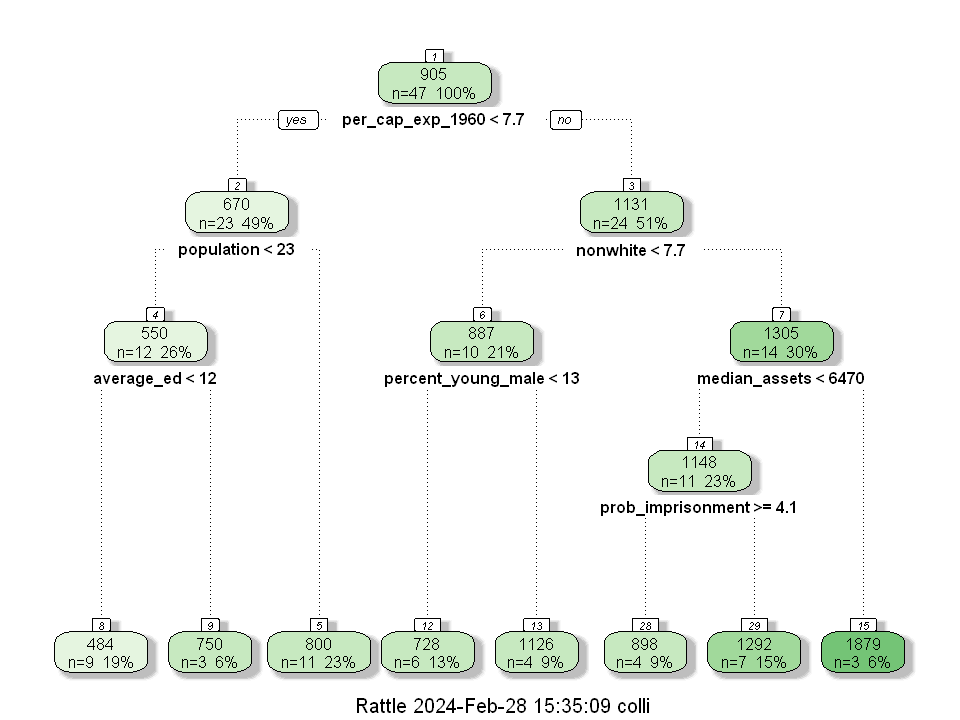

In [8]:
# Set the plot size
options(repr.plot.width=8, repr.plot.height=6)

# Create the plot
fancyRpartPlot(crime_tree)

I'll hold off on any qualitative takeaways from the plots until the end of the document but they both worked well. prp() has a ton of different options to create the plot exactly as you want it but both get the job done.

Lastly, I am going to look at the cptable element of the crime_tree generated by rpart. The cptable provides a brief summary of the overall fit of the model. The table is printed from the smallest tree (no splits) to the largest tree. The “CP” column lists the values of the complexity parameter, the number of splits is listed under "nsplit", and the column "xerror" contains cross-validated classification error rates; the standard deviation of the cross-validation error rates are in the "xstd" column.

In [9]:
crime_tree$cptable

CP,nsplit,rel error,xerror,xstd
0.36296293,0,1.0000000,1.062718,0.2641620
0.16540024,1,0.6370371,1.131172,0.2744131
0.05730143,3,0.3062366,1.292726,0.3268601
0.05538867,4,0.2489352,1.152379,0.3190650
0.05173165,5,0.1935465,1.178961,0.3179641
0.02305931,6,0.1418148,1.172783,0.3249076
0.01000000,7,0.1187555,1.146689,0.3351339


Normally, we select a tree size that minimizes the cross-validated error (xerror). That would actually mean pruning all of the branches and just being left with the root node... This is a pretty good indicator that the CART model isn't a good fit for this analysis.

#### Step 4 - Prune the Tree
Next I am going to prune the tree, since we used the entire set of data to train the model I can't calculate the estimation error to see if each branch increases error. Instead, I am going to prune the tree based on setting the cp threshold. To perform pruning, you normally choose a cp value that balances model complexity (number of splits) with predictive accuracy (xerror). The optimal cp value is typically chosen as the one associated with the smallest tree within one standard error of the minimum xerror, however this isn't possible since that value corresponds with the root node.

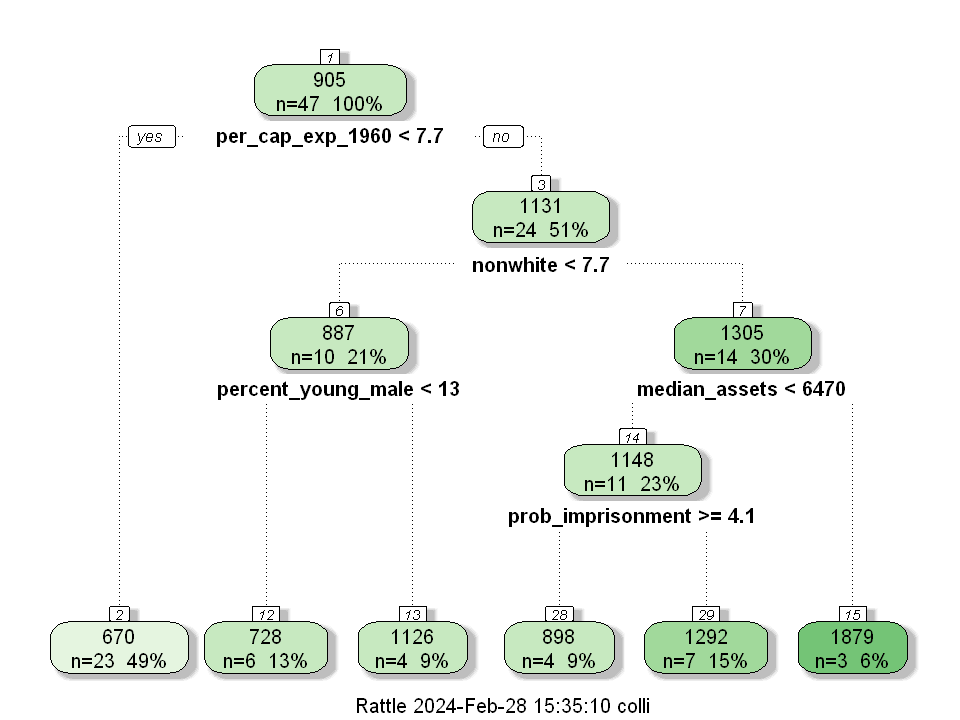

In [10]:
pruned_crime_tree <- prune(crime_tree, cp = 0.0525)
fancyRpartPlot(pruned_crime_tree)

#### Step 5 - Interpret the Results
Now that I have the final model I am going to spend some time analyzing it's overall performance. I want to look at how accurately it predicted the crime rates both graphically and using the R^2 value with and without cross-validation. I'll start by plotting the predicted values vs. the actual values.

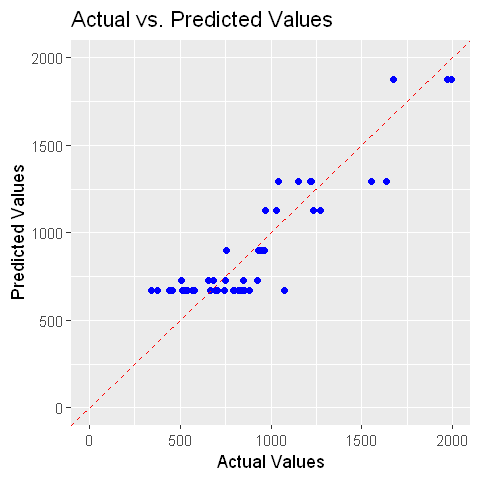

In [11]:
# Get predicted values from the model
pred <- predict(pruned_crime_tree)

# Plot the predicted values vs the actual values for crimes per million
plot_data <- data.frame(Actual = crime_data$crimes_per_million, Predicted = pred)
options(repr.plot.width=4, repr.plot.height=4)

# Create a scatter plot
ggplot(plot_data, aes(x = Actual, y = Predicted)) +
    geom_point(color = "blue") +
    geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") +  # Add a line of equality
    labs(x = "Actual Values", y = "Predicted Values", title = "Actual vs. Predicted Values") +
    xlim(0, 2000) +
    ylim(0, 2000)

This graph shows how the different final values are distributed among the actual values. You can distinctly see the 6 different possible predicted values and the distribution of actual values they cover. Next I'll calculate the R-Squared value using the training data.

In [12]:
# Calculate the R-Squared and RMSE value
SSR <- sum((pred - crime_data$crimes_per_million)^2)
SST <- sum((crime_data$crimes_per_million - mean(crime_data$crimes_per_million))^2)
R2 <- 1 - SSR/SST

RMSE <- sqrt((SSR)/nrow(crime_data))
cat('R-Squared value for the training data:', round(R2,3), '\n')
cat('RMSE value for the training data:', RMSE)

R-Squared value for the training data: 0.806 
RMSE value for the training data: 168.3322

This shows a reasonable fit for the training dataset, I suspect it is overfitting so next I'll use cross validation to calculate the R-Squared value again.

In [13]:
# 5-fold cross-validation
# Set the parameters for the model
ctrl <- trainControl(method = "cv", number = 5)
rpart_params <- list(split = "anova", minsplit = 9)

# Perform cross-validation
cv_model <- train(crimes_per_million ~ ., data = crime_data, method = "rpart", trControl = ctrl, tuneLength = 10, parms = rpart_params)

# Get R^2 and RMSE values
cv_model$results

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."

cp,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
0.00000000,331.2935,0.30233684,270.2860,115.31931,0.27902045,95.01692
0.04032921,331.0697,0.30189365,273.3767,115.02224,0.27943322,99.56268
0.08065843,339.4182,0.27995110,278.1480,110.66839,0.30112875,97.48590
0.12098764,347.2662,0.21832683,282.2159,95.60076,0.22825680,90.24611
0.16131686,344.5430,0.22314361,273.8537,93.75588,0.22508572,85.42627
0.20164607,344.5430,0.22314361,273.8537,93.75588,0.22508572,85.42627
0.24197529,344.5430,0.22314361,273.8537,93.75588,0.22508572,85.42627
0.28230450,344.5430,0.22314361,273.8537,93.75588,0.22508572,85.42627
0.32263372,366.6472,0.13957395,290.9037,111.38682,0.14488680,92.09223
0.36296293,377.8427,0.07093795,304.8309,92.17892,0.05677036,69.12573


The first thing I noticed is the warning message that is provided. It indicates that there were missing values in the resampled performance measures during the cross-validation process. This warning typically occurs when one or more folds of the cross-validation procedure result in missing performance metrics. One possible reason would be if it created degenerate folds which happens when the data is small and one or more of the folds potentially has empty classes. With how small the dataset is this is definitely possible.

My final model pruned to cp values at or above 0.0525 which lies between the second and third row in the table. Looking at the R-Squared value it is ~ 0.30 which is much lower than the R-Squared value calculated on the training data. Comparing the RMSE values it also shows much higher values in the cross-validated model vs. the model that only used training data. **This suggest significant overfitting.**

### Random Forest Model

Next I am going to create a Random Forest model using the randomForest package and then evaluate it's performance. I plan to follow the steps below:
1) Create Model
2) Analyze Model Performance
3) Compare model to CART model from part A

#### Step 1 - Create Model
There are a lot of parameters that can be set for the random forest model which can be found here: https://www.rdocumentation.org/packages/randomForest/versions/4.7-1.1/topics/randomForest. I played around with several different parameters, specifically the mtry, nodesize, and maxnodes. The mtry parameter is the number of variables randomly sampled as candidates at each split which defaults to p/3 for regression. This would be 5 for our sample since we have 15 dependent variables. The nodesize determines the minimum size of terminal nodes which defaults to 5 for regression. The maxnodes paramater determines the maximum number of terminal nodes the trees in the forest can have.

In [14]:
crime_rforest <- randomForest(crimes_per_million ~ ., data = crime_data, mtry = 3, nodesize = 3, maxnodes = 25, importance = TRUE)
crime_rforest


Call:
 randomForest(formula = crimes_per_million ~ ., data = crime_data,      mtry = 3, nodesize = 3, maxnodes = 25, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 3

          Mean of squared residuals: 83197.59
                    % Var explained: 43.17

#### Step 2 - Analyze the Model
Looking at the result above the model is able to describe ~ 43% of the variance in the dependent variable which is the same thing as saying the R-Squared value is 0.4527. It also has a RMSE of ~288 (square root of Mean of squared residuals). Next I am going to plot the predicted values from the model vs. the actual values to visualize the models performance.

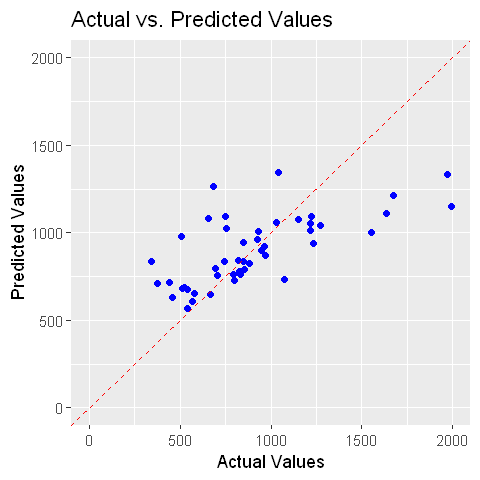

In [15]:
# Get predicted values from the model
rf_pred <- predict(crime_rforest)

# Create a dataframe of predicted and actual values to plot
rf_plot_data <- data.frame(Actual = crime_data$crimes_per_million, Predicted = rf_pred)

# Plot the predicted values vs the actual values for crimes per million
ggplot(rf_plot_data, aes(x = Actual, y = Predicted)) +
    geom_point(color = "blue") +
    geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") +  # Add a line of equality
    labs(x = "Actual Values", y = "Predicted Values", title = "Actual vs. Predicted Values") +
    xlim(0, 2000) +
    ylim(0, 2000)

Next I am going to calculate the R-Squared and RMSE value manually, this is simply a check on the value output from the model above.

In [16]:
# Calculate the R-Squared value
rf_SSR <- sum((rf_pred - crime_data$crimes_per_million)^2)
rf_R2 <- 1 - rf_SSR/SST

# Calculate the RMSE
rf_RMSE <- sqrt((rf_SSR)/nrow(crime_data))

cat('R-Squared value for the Random Forest model built with training data:', round(rf_R2,3), '\n')
cat('RMSE value for the Random Forest model built with training data:', rf_RMSE)

R-Squared value for the Random Forest model built with training data: 0.432 
RMSE value for the Random Forest model built with training data: 288.4399

These values match the output from the model above, it's nice when things check out like that :)

Next I will calculate the R-Squared and RMSE using cross-validation.

In [17]:
# 5-fold cross-validation
# Set the parameters for the model
rf_ctrl <- trainControl(method = "cv", number = 5)
rf_params <- list(nodesize = 3, maxnodes = 25)

# Perform cross-validation
rf_cv_model <- train(crimes_per_million ~ ., data = crime_data, method = "rf", tuneLength = 10, trControl = ctrl, parms = rf_params)

# Print the model to view the results
print(rf_cv_model)

Random Forest 

47 samples
15 predictors

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 37, 37, 38, 38, 38 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
   2    281.9872  0.4993885  213.7193
   3    277.6091  0.4811486  208.7167
   4    285.6385  0.4386798  213.7613
   6    283.2740  0.4389022  209.4042
   7    283.9091  0.4347107  209.4308
   9    288.3659  0.4166768  211.2063
  10    289.1673  0.4234507  213.7562
  12    293.6504  0.4043417  215.6539
  13    295.1157  0.4048620  215.7577
  15    293.7088  0.4144728  214.6193

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 3.


These results are very suprising, when looking at the R-Squared values for mtry = 3 in the cross validated model it is actually larger than the model trained on the full training dataset. The RMSE is slightly lower as well. Looking into this I did find that it isn't totally uncommon. During cross-validation, the model is trained multiple times on different subsets of the data, which can help prevent overfitting by penalizing overly complex models. As a result, the cross-validated model may generalize better to unseen data, leading to higher performance metrics. The metrics above show that **the Random Forest did perform better than the CART model and has less of an issue with overfitting.**